# SI 618 Homework 6: Clustering

## The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, puctuation, etc. of written sentences.
- 10 pt: Code is written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

## Top-level Goal
Your overall goal in this assignment is to cluster airplane incidents according to the text contained in the summaries of the incidents.  This will provide an opportunity for you to apply the methods we talked about in the lecture. 

You should pick a decade (i.e. any contiguous 10-year span) of air crashes data, focus on the column called "summary" and try to cluster the air crashes based on these summaries using both hierarchical and k-means clustering.

Hint:
- Be careful with the choice of decade, some decades do not have sufficient data to play with.
- pandas.to_datetime is a useful function for transforming string-based dates to datetime objects in a dataframe.
- It's necessary to clean the data before you formally begin to answer the questions.

# Q1 (5 points) Download and describe the data
You can download the air crash dataset through this [page](https://opendata.socrata.com/Government/Airplane-Crashes-and-Fatalities-Since-1908/q2te-8cvq). Download the .csv file (Airplane_Crashes_and_Fatalities_Since_1908.csv) and explore the dataset in the same way as you explored the Pokemon dataset in this week's class.  You should use graphical and analytic methods to describe the data as completely as possible.

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
from wordcloud import WordCloud
from sklearn import metrics
from spacy.lang.en.stop_words import STOP_WORDS
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

nlp = spacy.load(r'C:\Users\dteng\Anaconda\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.0.0')
# nlp = spacy.load(r'C:\Users\mrasianman3\Anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.0.0')

%matplotlib inline
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [3]:
df = pd.read_csv(r'data/Airplane_Crashes_and_Fatalities_Since_1908.csv', delimiter = ',')
df.Date = pd.to_datetime(df.Date)
df.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,1908-09-17,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,1912-07-12,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,1913-08-06,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,1913-09-09,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,1913-10-17,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


In [4]:
df.describe(include = 'all')

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
count,5268,3049,5248,5250,1069,3562,5241,4933,4040,5246.000000,5256.000000,5246.000000,4878
unique,4753,1005,4303,2476,724,3244,2446,4905,3707,NaN,NaN,NaN,4673
top,1973-02-28 00:00:00,15:00,"Sao Paulo, Brazil",Aeroflot,-,Training,Douglas DC-3,49,178,NaN,NaN,NaN,Crashed during takeoff.
freq,4,32,15,179,67,81,334,3,6,NaN,NaN,NaN,15
first,1908-09-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2009-06-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.554518,20.068303,1.608845,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.076711,33.199952,53.987827,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,3.000000,0.000000,NaN


For categorical/string variables, this table describes the most frequent occurence. For example:
- Moscow, Russia appears to be the most frequent place aviation accidents occur (15
- Aeroflot is the Operator that has the most accidents (179)
- Training flights seem to be accident prone (81)
- The Douglas DC-3 is the aircraft with the most number of crashes (334)
- Takeoffs seem to be the most dangerous part of the crash when summarized (15)


On average, air crashes will have about 28 people on board, kill around 20 people, and around 2 people on the groud will die.

In [5]:
def get_decade(row):
    return int(row.Date.year / 10) * 10

df['Decade'] = df.apply(get_decade, axis = 1)
df.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,Decade
0,1908-09-17,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly...",1900
1,1912-07-12,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...,1910
2,1913-08-06,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...,1910
3,1913-09-09,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...,1910
4,1913-10-17,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...,1910


Text(0, 0.5, 'Crashes')

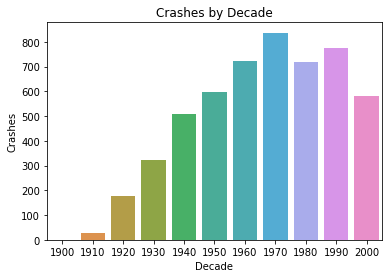

In [6]:
ax = sns.countplot(df.Decade)
ax.set_title('Crashes by Decade')
ax.set_ylabel('Crashes')

The above figure plots the distribution of crashes by decade. The 1970s have the most crashes. Of interest, there significantly less crashes during the 1940s than expected, given that World War II occurred during this period. This can be attributed to the fact that combat losses are not recorded accurately in this dataset.

Text(0.5, 1.0, 'Total Fatalities by Decade')

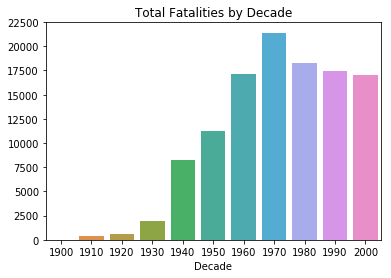

In [7]:
ax = sns.barplot(x = df.Decade, y = df.Fatalities + df.Ground, ci = None, estimator = sum)
ax.set_title('Total Fatalities by Decade')

The above figure plots the distribution of fatalities (including ground fatalities). The 1970s, similar to the previous figure, has the most fatalities.

***Because of this EDA, I will be working with the 1970s only***

# Q2 (10 pts): Create a roadmap to process the data
Think of how you will solve the problems in different steps.  What kind of data you need to prepare for clustering? How would you run clustering algorithms on the dataset?  Please write down your thoughts below and specify your expectations of the clustering results.

In [8]:
df_1970 = df.set_index('Decade')
df_1970 = df_1970.loc[1970]
df_1970.reset_index(drop = True, inplace = True)
df_1970.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,1970-02-13,NaN,"Pin-la-Garenne, France",Avia-Taxi,NaN,NaN,Cessna 402,F-BPJA,402-0100,10.0,10.0,0.0,NaN
1,1973-05-11,NaN,"Near Semipalatinsk, USSR",Aeroflot,NaN,NaN,Ilyushin IL-18B,SSR-75687,189001202,61.0,61.0,0.0,NaN
2,1973-10-12,NaN,"Acapulco, Mexico",Avionas Banamex,NaN,NaN,de Havilland DH-125-1A,XA-COL,25086,8.0,8.0,0.0,Crashed while approaching to land.
3,1973-10-15,NaN,"Fort Smith AFB, Oklahoma",Military - U.S. Air Force,NaN,NaN,Lockheed C-130E Hercules,62-1845,3808,7.0,7.0,0.0,Crashed into a mountain.
4,1975-07-31,NaN,"Santiago, Chili",Military - Chilian Air Force,NaN,NaN,Douglas C-47,970,NaN,10.0,10.0,0.0,NaN


1) Pre-process text to create frequency vectors.  
2) Run clustering algorithms based on the methods from class.  
3) Use hierarchical and k-clustering to do clustering.  
4) Results will group accidents by similarities.

# Q3 (20 pts): Text processing
With each summary, we want to transform the text into a frequency vector. For example, if we have two summaries:
- "The plane was crashed with no alarms. Checking the plane."
- "The plane was crashed on a mountain. "

After some basic text processing such as lowercases and removing stop words, you can create a frequency dataframe like this:

![Frequency Table](freq_table.png)

Please transpose the dataframe (pandas.DataFrame.transpose) and represent each summary as a frequency vector:

![Freq Table T](freq_table_t.png)

We will calculate the similarity between the summaries and run clustering algorithms based on this frequency tables.

In [9]:
def remove_stop(row):
    try:
        doc = nlp(row['summary'])
        return [token.text for token in doc if not token.is_stop if not token.is_punct]
    except:
        return []

df_1970['summary'] = df_1970.Summary.str.lower()
df_1970.summary = df_1970.apply(remove_stop, axis = 1)
df_1970.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,summary
0,1970-02-13,NaN,"Pin-la-Garenne, France",Avia-Taxi,NaN,NaN,Cessna 402,F-BPJA,402-0100,10.0,10.0,0.0,NaN,[]
1,1973-05-11,NaN,"Near Semipalatinsk, USSR",Aeroflot,NaN,NaN,Ilyushin IL-18B,SSR-75687,189001202,61.0,61.0,0.0,NaN,[]
2,1973-10-12,NaN,"Acapulco, Mexico",Avionas Banamex,NaN,NaN,de Havilland DH-125-1A,XA-COL,25086,8.0,8.0,0.0,Crashed while approaching to land.,"[crashed, approaching, land]"
3,1973-10-15,NaN,"Fort Smith AFB, Oklahoma",Military - U.S. Air Force,NaN,NaN,Lockheed C-130E Hercules,62-1845,3808,7.0,7.0,0.0,Crashed into a mountain.,"[crashed, mountain]"
4,1975-07-31,NaN,"Santiago, Chili",Military - Chilian Air Force,NaN,NaN,Douglas C-47,970,NaN,10.0,10.0,0.0,NaN,[]


In [106]:
df_1970.shape

(837, 14)

In [11]:
unique = []
for index, row in df_1970.iterrows():
    for word in row.summary:
        if word not in unique:
            unique.append(word)
            
df_freq = pd.DataFrame(data = unique)
df_freq.columns = ['word']

for index, row in df_1970.iterrows():
    _index = 'summary%d' % (index + 1)
    df_freq[_index] = 0
    for word in row.summary:
        if word in unique:
            _row = unique.index(word)
            df_freq.at[_row, _index] += 1
            
df_freq.head()

,word,summary1,summary2,summary3,summary4,summary5,summary6,summary7,summary8,summary9,...,summary828,summary829,summary830,summary831,summary832,summary833,summary834,summary835,summary836,summary837
0,crashed,0,0,1,1,0,1,0,1,1,...,1,1,0,1,0,0,0,1,1,1
1,approaching,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,land,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,mountain,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
4,high,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df_freq_trans = df_freq.set_index('word').transpose()
df_freq_trans.head()

word,crashed,approaching,land,mountain,high,ground,descending,emergency,flight,airlift,...,antarctica,computer,stored,directing,inexperience,antarctiroute,suppressed,hotel,cubuk,trabzon
summary1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
summary2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
summary3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
summary4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
summary5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Q4 (20 pts): Clustering
- Please run both the hierarchical clustering and k-means algorithms on the created dataframe.
- What do the results look like? Drawing the hierarachical clustering dendrogram may be helpful (or it might not -- how would you simplify an overly dense dendrogram?).
- How did you choose the number of clusters? For k-means clustering, please use the four methods mentioned in our lecture to choose an appropriate number of clusters.

In [125]:
model = AgglomerativeClustering(n_clusters=837) # we can make up the value for clusters
model.fit_predict(df_freq_trans)

array([836, 785, 746, 834, 835, 707, 823, 543, 669, 751, 467, 667, 495,
       629, 615, 417, 833, 557, 773, 567, 759, 587, 419, 611, 832, 575,
       461, 708, 489, 775, 631, 604, 681, 490, 778, 653, 714, 674, 639,
       831, 589, 821, 463, 740, 768, 488, 455, 551, 651, 738, 815, 469,
       479, 481, 670, 627, 830, 510, 652, 799, 642, 696, 827, 725, 736,
       646, 334, 752, 566, 723, 555, 585, 671, 753, 427, 547, 709, 761,
       701, 591, 649, 588, 440, 464, 325, 509, 579, 456, 679, 737, 583,
       598, 415, 499, 545, 444, 622, 786, 470, 437, 375, 478, 617, 485,
       643, 570, 811, 548, 434, 552, 474, 777, 743, 503, 525, 632, 435,
       628, 783, 771, 719, 486, 487, 511, 497, 673, 613, 618, 663, 779,
       727, 526, 648, 645, 556, 731, 531, 619, 507, 772, 609, 451, 553,
       829, 482, 685, 562, 690, 739, 501, 644, 735, 776, 475, 577, 770,
       732, 336, 767, 641, 442, 420, 468, 650, 449, 367, 817, 387, 418,
       321, 730, 517, 416, 275, 750, 527, 592, 765, 477, 769, 45

In [118]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

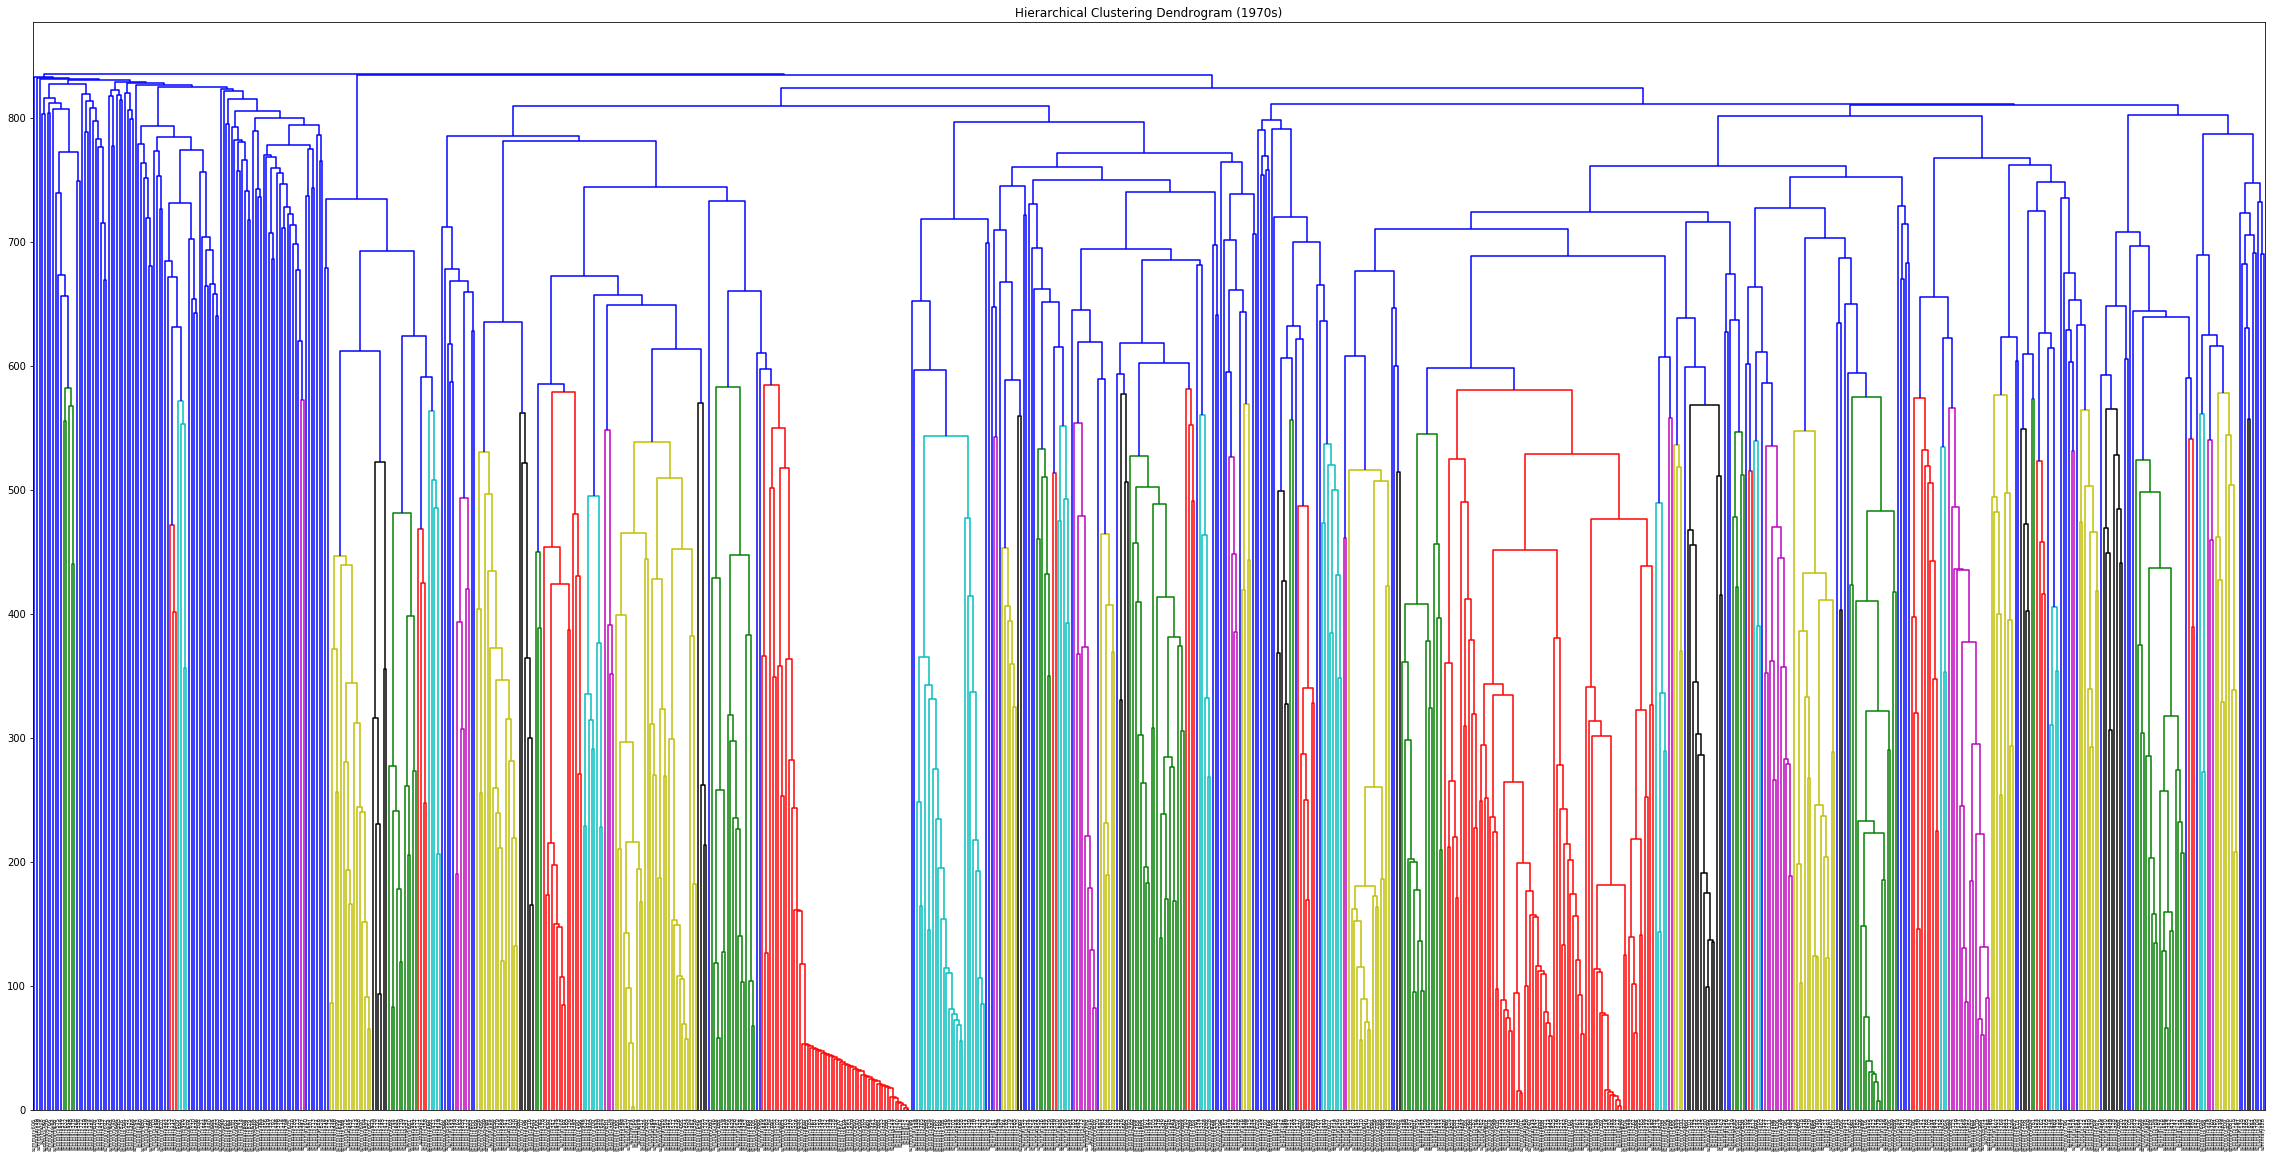

In [130]:
plt.figure(figsize = (40, 20))
plt.xticks(rotation = 90)
plt.title('Hierarchical Clustering Dendrogram (1970s)')
plot_dendrogram(model,labels=df_freq_trans.index.values)
plt.savefig('HCD_crashes.pdf',format='pdf')

In [16]:
k1 = 3
k2 = np.sqrt(len(df_freq_trans) / 2)
print(k2)

kmeans = KMeans(n_clusters = 3) # start with 3 clusters for educated guess
kmeans.fit(df_freq_trans)

20.457272545478784


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

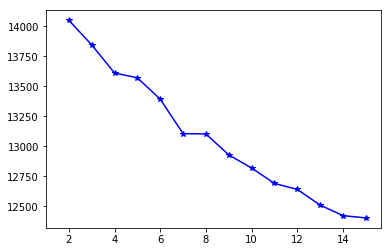

In [20]:
cost = []
for k in range(2, 16):
    k_means = KMeans(init='k-means++', n_clusters = k, n_init = 10)
    k_means.fit(df_freq_trans)
    cost.append(k_means.inertia_)

fig, ax = plt.subplots()
plt.plot(range(2, 16), cost, 'b*-')
plt.xlim(1, plt.xlim()[1])
k3 = 8 # Pretty obvious where the turning point is

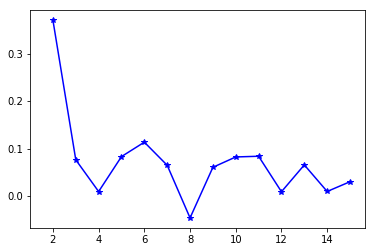

In [145]:
cost = []
for k in range(2, 16):
    k_means = KMeans(init = 'k-means++', n_clusters = k, n_init = 10)
    k_means.fit(df_freq_trans)
    cost.append(metrics.silhouette_score(df_freq_trans, k_means.labels_))

# kIdx = np.argmax(cost)
fig, ax = plt.subplots()
plt.plot(range(2, 16), cost, 'b*-')
plt.xlim(1, plt.xlim()[1])
k4 = 8 # Seems to be the largest local minimum

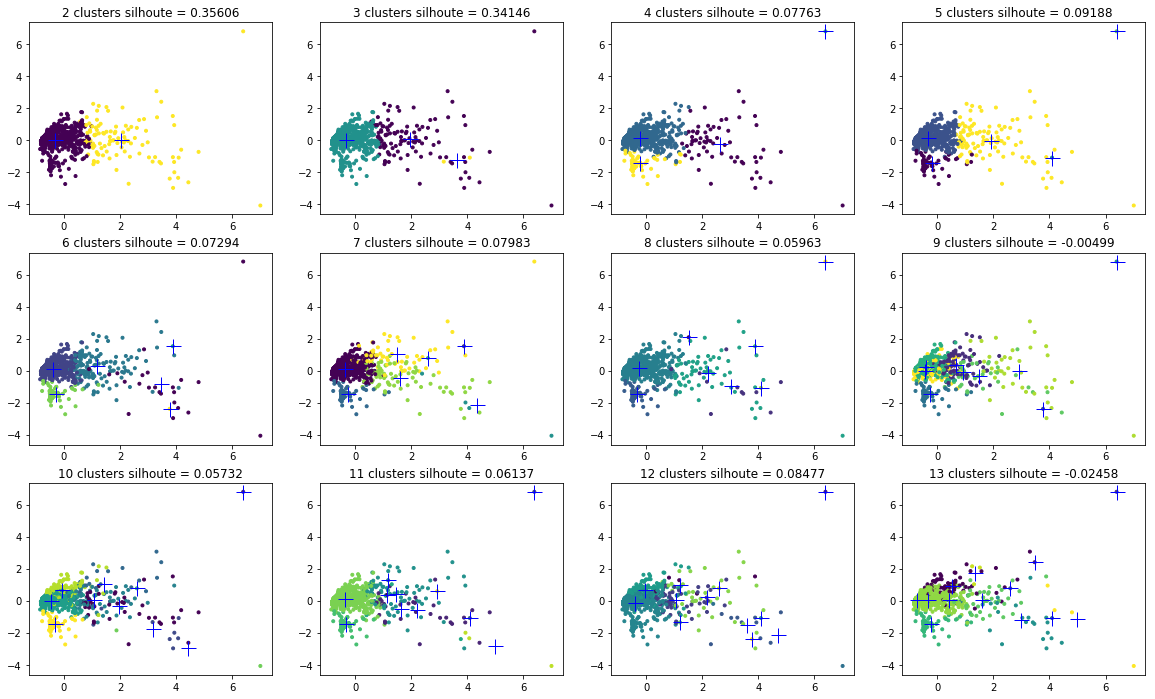

In [19]:
pca = PCA(n_components = 2).fit(df_freq_trans)
data2d = pca.transform(df_freq_trans)

plt.figure(figsize=(20, 12))
scores, n_clusters, preds = [], [], []
for i in range(2, 14):
    kmean = KMeans(n_clusters = i).fit(df_freq_trans)
    scores.append(kmean.score(df_freq_trans))
    n_clusters.append(i)
    pred = kmean.predict(df_freq_trans)
    preds.append(pred)
    plt.subplot(3, 4, i - 1)
    plt.title(f"{i} clusters silhoute = {np.round(silhouette_score(df_freq_trans, pred), decimals = 5)}")
    plt.scatter(data2d[:, 0], data2d[:, 1], c = pred, marker = '.')
    
    centroids = kmean.cluster_centers_
    centroids2d = pca.transform(centroids)
    plt.plot(centroids2d[:, 0], centroids2d[:, 1], 'b+', markersize=15)
    
k4 = 6

# Q5 (20 pts): Explain your clustering results
- How can you explain your clustering results? What kind of summaries are included in each cluster?
- Could you select some representative examples for each cluster?
- Word cloud, which has been used in the last assignment, may be helpful for understanding the clustering results

In [27]:
kmean = KMeans(n_clusters = 6).fit(df_freq_trans)
df_1970['clusters'] = kmean.labels_
df_1970.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,summary,clusters
0,1970-02-13,NaN,"Pin-la-Garenne, France",Avia-Taxi,NaN,NaN,Cessna 402,F-BPJA,402-0100,10.0,10.0,0.0,NaN,[],5
1,1973-05-11,NaN,"Near Semipalatinsk, USSR",Aeroflot,NaN,NaN,Ilyushin IL-18B,SSR-75687,189001202,61.0,61.0,0.0,NaN,[],5
2,1973-10-12,NaN,"Acapulco, Mexico",Avionas Banamex,NaN,NaN,de Havilland DH-125-1A,XA-COL,25086,8.0,8.0,0.0,Crashed while approaching to land.,"[crashed, approaching, land]",5
3,1973-10-15,NaN,"Fort Smith AFB, Oklahoma",Military - U.S. Air Force,NaN,NaN,Lockheed C-130E Hercules,62-1845,3808,7.0,7.0,0.0,Crashed into a mountain.,"[crashed, mountain]",5
4,1975-07-31,NaN,"Santiago, Chili",Military - Chilian Air Force,NaN,NaN,Douglas C-47,970,NaN,10.0,10.0,0.0,NaN,[],5


In [38]:
# Collaborated with Jackson Hammond

def cloudMaker(i):
    summary_array = df_1970[df_1970.clusters == i].summary
    summary_array = summary_array.apply(lambda x: ' '.join(x))
    summary_array = summary_array.tolist()
    summary_array = ' '.join(summary_array)
    
    wordcloud = WordCloud().generate(summary_array)
    
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')

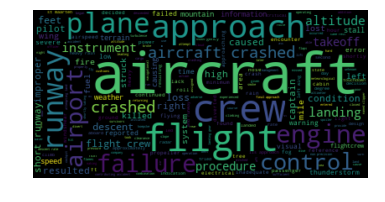

In [39]:
cloudMaker(0)

Group 0 seems to be describing aircraft that crashed while landing, whether from losing control or missed procedures.

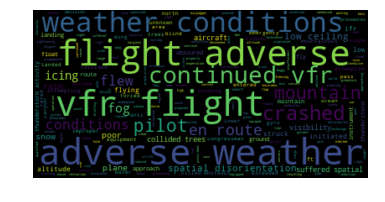

In [40]:
cloudMaker(1)

Group 1 describes aircraft that crashed during adverse weather conditions, as well as on visual approaches to the runway during adverse weather.

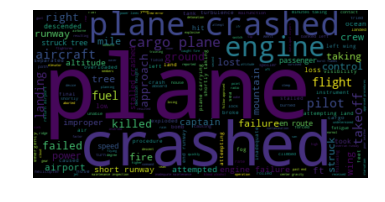

In [41]:
cloudMaker(2)

Group 2 seems to describe issues with engines that caused the plane to crash.

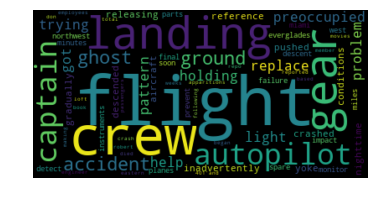

In [42]:
cloudMaker(3)

Group 3 describes crashes attributed to crew error, whether it be crew inattentiveness while on autopilot or crew accidently/deliberately leading to the crash happening.

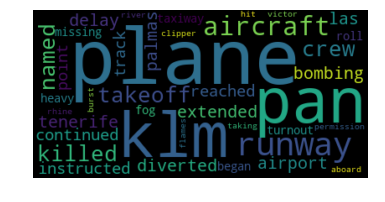

In [43]:
cloudMaker(4)

Group 4 talks solely about the Tenerife airport disaster, the deadliest crash in aviation history. KLM Flight 4805 and Pan Am Flight 1736 crashed on the runway at Tenerife Airport, after being diverted after a bombing at Gran Canaria Airport. Because of crew hour restrictions, the KLM captain decided to immediately take-off. Miscommunication with the tower, who used non-standard English on runway procedures, caused the KLM flight to crash into the Pan Am flight while the latter was taxiing across the runway. The only survivors were on the Pan Am flight; the KLM flight rammed the upper-middle section of the Pan Am flight, and exploded into flames further down the runway.

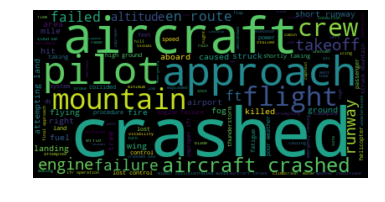

In [44]:
cloudMaker(5)

The final grouop talks about aircraft crashing on approach in mountainous terrain.

# Q5 (5 pts): Reflect on your thoughts
When you completes the clustering, please look back to your original plan for the clustering. 
- Within your plan, which steps are actually taken eventually? Which are not?  What modifications did you make to your planned process?
- Are the clustering results different from your expectations? Did you find anything unexpected or surprising?

Of the steps I took, all were part of the process.  
I was not expecting that a single group would actually describe only a single disaster, rather than a class of disasters.  
There were also multiple clusters describing slightly different types of accidents upon landing; given that landing is considered the most dangerous part of aviation, this makes sense.